## This code tests for stationarity & correlation in spreads / spreads-of-spreads. Builds a garch vol model and runs a backtest.

### Load data - polars only + vectorized operations to speed up everything

In [1]:
import polars as pl
from pathlib import Path
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm
import warnings
from typing import Dict, Tuple
warnings.filterwarnings('ignore')

# Configuration parameters
SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
DATA_DIR = Path("coinbase/5m")
SIGNIFICANCE_LEVEL = 0.05
MIN_OBSERVATIONS = 100

columns = ["timestamp", "open", "high", "low", "close", "volume"]

def drop_nan_rows(df):
    mask = ~(
        df["open"].is_nan() |
        df["high"].is_nan() |
        df["low"].is_nan() |
        df["close"].is_nan() |
        df["volume"].is_nan()
    )
    return df.filter(mask)

dataframes = {}

print("Loading data files...")
for symbol in tqdm(SYMBOLS, desc="Loading symbols"):
    symbol_dfs = []
    for year_dir in DATA_DIR.iterdir():
        if year_dir.is_dir():
            file_path = year_dir / f"{symbol}_5m_{year_dir.name}.csv"
            if file_path.exists():
                df = pl.read_csv(file_path, has_header=False, new_columns=columns)
                df = drop_nan_rows(df)
                symbol_dfs.append(df)

    if symbol_dfs:
        combined_df = pl.concat(symbol_dfs)
        combined_df = combined_df.with_columns(
            (pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).alias("timestamp")
        )
        dataframes[symbol] = combined_df
    else:
        print(f"No files found for {symbol}")

Loading data files...


Loading symbols: 100%|██████████| 4/4 [00:00<00:00, 15.38it/s]


### Make spread & spread-of-spread dataframes [ ratio of close ]

In [2]:
from itertools import combinations

def compute_spread_df(df1, df2, name1, name2):
    joined = df1.join(df2, on="timestamp", how="inner", suffix="_" + name2)
    spread = joined.with_columns(
        (pl.col("close") / pl.col(f"close_{name2}")).alias(f"{name1}_{name2}_spread")
    ).select(["timestamp", f"{name1}_{name2}_spread"])
    return spread

def compute_spread_of_spreads_df(spread_df1, spread_df2, name1, name2):
    joined = spread_df1.join(spread_df2, on="timestamp", how="inner", suffix="_2")
    col1 = f"{name1}_spread"
    col2 = f"{name2}_spread"
    spread_of_spreads = joined.with_columns(
        (pl.col(col1) / pl.col(col2)).alias(f"{name1}_over_{name2}_spread")
    ).select(["timestamp", f"{name1}_over_{name2}_spread"])
    return spread_of_spreads

# Generate all spreads
spread_dfs = {}
symbols = list(dataframes.keys())

print("Computing spreads...")
for sym1, sym2 in tqdm(list(combinations(symbols, 2)), desc="Computing spreads"):
    df1 = dataframes[sym1]
    df2 = dataframes[sym2]
    spread_name = f"{sym1}_{sym2}"
    spread_df = compute_spread_df(df1, df2, sym1, sym2)
    spread_dfs[spread_name] = spread_df

# Generate all spread-of-spreads
spread_of_spreads_dfs = {}

print("Computing spread-of-spreads...")
for (spread1_name, spread2_name) in tqdm(list(combinations(spread_dfs.keys(), 2)), desc="Computing spread-of-spreads"):
    spread_df1 = spread_dfs[spread1_name]
    spread_df2 = spread_dfs[spread2_name]
    sos_name = f"{spread1_name}_OVER_{spread2_name}"
    sos_df = compute_spread_of_spreads_df(spread_df1, spread_df2, spread1_name, spread2_name)
    spread_of_spreads_dfs[sos_name] = sos_df

Computing spreads...


Computing spreads: 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


Computing spread-of-spreads...


Computing spread-of-spreads: 100%|██████████| 15/15 [00:00<00:00, 107.16it/s]


### Rolling correlation + cointegration [time series tests]

In [3]:
# TIME SERIES FUNCTIONS / TESTS

def adf_test(series):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity of a time series.
    The ADF test tests the null hypothesis that the series has a unit root (i.e., is non-stationary).
    If the p-value is below the significance level, we reject the null and conclude the series is stationary.
    """
    try:
        if len(series) < MIN_OBSERVATIONS:
            return None
        clean_series = series[np.isfinite(series)]
        if len(clean_series) < MIN_OBSERVATIONS:
            return None
        
        # Use fewer lags for speed
        result = adfuller(clean_series, maxlag=min(10, len(clean_series)//10), autolag='AIC')
        return {
            'p_value': result[1],
            'is_stationary': result[1] < SIGNIFICANCE_LEVEL
        }
    except:
        return None

def kpss_test(series):
    """
    Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity of a time series.
    Unlike ADF, KPSS tests the null hypothesis that the series is stationary around a constant (or trend).
    If the p-value is above the significance level, we fail to reject stationarity; otherwise, the series is non-stationary.
    """
    try:
        if len(series) < MIN_OBSERVATIONS:
            return None
        clean_series = series[np.isfinite(series)]
        if len(clean_series) < MIN_OBSERVATIONS:
            return None
        
        result = kpss(clean_series, regression='c', nlags='auto')
        return {
            'p_value': result[1],
            'is_stationary': result[1] > SIGNIFICANCE_LEVEL
        }
    except:
        return None

def correlation_test(series1, series2):
    """
    Compute the Pearson correlation coefficient between two series.
    This measures the linear relationship between the two series.
    Returns the correlation value, p-value, and whether the correlation is statistically significant.
    """
    try:
        if len(series1) < MIN_OBSERVATIONS or len(series2) < MIN_OBSERVATIONS:
            return None
        
        mask = np.isfinite(series1) & np.isfinite(series2)
        clean_series1 = series1[mask]
        clean_series2 = series2[mask]
        
        if len(clean_series1) < MIN_OBSERVATIONS:
            return None
        
        corr, p_value = pearsonr(clean_series1, clean_series2)
        return {
            'correlation': corr,
            'p_value': p_value,
            'is_significant': p_value < SIGNIFICANCE_LEVEL
        }
    except:
        return None

def cointegration_test(series1, series2):
    """
    Perform the Engle-Granger cointegration test to determine if two non-stationary series are cointegrated.
    Cointegration implies a stable long-term relationship despite individual non-stationarity.
    The null hypothesis is no cointegration; a low p-value means rejecting null, thus cointegrated.
    """
    try:
        if len(series1) < MIN_OBSERVATIONS or len(series2) < MIN_OBSERVATIONS:
            return None
        
        mask = np.isfinite(series1) & np.isfinite(series2)
        clean_series1 = series1[mask]
        clean_series2 = series2[mask]
        
        if len(clean_series1) < MIN_OBSERVATIONS:
            return None
        
        # Use fewer lags for speed
        statistic, p_value, _ = coint(clean_series1, clean_series2)
        return {
            'p_value': p_value,
            'is_cointegrated': p_value < SIGNIFICANCE_LEVEL
        }
    except:
        return None

def extract_series_fast(df, column_name):
    """
    Efficiently extract a column from a dataframe as a numpy array.
    This speeds up numerical computations and tests on the series.
    """
    return df.get_column(column_name).to_numpy()

def time_series_analysis(df, series_name, column_name):
    """
    Perform streamlined analysis on a single time series.
    Returns basic statistics (mean, std), number of observations,
    and results of stationarity tests (ADF and KPSS).
    """
    series = extract_series_fast(df, column_name)
    
    return {
        'series_name': series_name,
        'n_observations': len(series),
        'mean': float(np.mean(series)),
        'std': float(np.std(series)),
        'adf_test': adf_test(series),
        'kpss_test': kpss_test(series)
    }

def pairwise_analysis(df1, df2, name1, name2, col1, col2):
    """
    Perform pairwise analysis between two time series.
    Computes correlation and cointegration tests, returning the results in a dictionary.
    """
    series1 = extract_series_fast(df1, col1)
    series2 = extract_series_fast(df2, col2)
    
    return {
        'pair': f"{name1}_vs_{name2}",
        'correlation': correlation_test(series1, series2),
        'cointegration': cointegration_test(series1, series2)
    }

def analyze_all_spreads():
    """
    Batch analysis of all spread time series.
    Iterates over all spreads, performing stationarity and basic stats analysis.
    """
    results = {}
    
    print("Analyzing spreads...")
    for spread_name, spread_df in tqdm(spread_dfs.items(), desc="Spread analysis"):
        column_name = f"{spread_name}_spread"
        results[spread_name] = time_series_analysis(spread_df, spread_name, column_name)
    
    return results

def analyze_all_sos():
    """
    Batch analysis of all spread-of-spreads (SoS) time series.
    Similar to spreads but for spread-of-spreads data.
    """
    results = {}
    
    print("Analyzing spread-of-spreads...")
    for sos_name, sos_df in tqdm(spread_of_spreads_dfs.items(), desc="SoS analysis"):
        column_name = f"{sos_name.replace('_OVER_', '_over_')}_spread"
        results[sos_name] = time_series_analysis(sos_df, sos_name, column_name)
    
    return results

def analyze_spread_pairs():
    """
    Batch pairwise analysis of all combinations of spreads.
    Computes correlation and cointegration for every unique pair of spreads.
    """
    results = {}
    
    # Pre-compute spread pairs to avoid repeated combinations
    spread_names = list(spread_dfs.keys())
    pairs = list(combinations(spread_names, 2))
    
    print(f"Analyzing {len(pairs)} spread pairs...")
    for spread1_name, spread2_name in tqdm(pairs, desc="Spread pairs"):
        df1 = spread_dfs[spread1_name]
        df2 = spread_dfs[spread2_name]
        col1 = f"{spread1_name}_spread"
        col2 = f"{spread2_name}_spread"
        
        pair_key = f"{spread1_name}_vs_{spread2_name}"
        results[pair_key] = pairwise_analysis(df1, df2, spread1_name, spread2_name, col1, col2)
    
    return results

# Pre-compute series data for faster access
def precompute_series_data():
    """
    Pre-extract all spread and spread-of-spread series data into numpy arrays.
    This allows faster repeated analysis without repeated dataframe extraction overhead.
    """
    spread_series = {}
    sos_series = {}
    
    print("Pre-computing series data...")
    # Extract spread series
    for spread_name, spread_df in tqdm(spread_dfs.items(), desc="Extracting spreads"):
        column_name = f"{spread_name}_spread"
        spread_series[spread_name] = extract_series_fast(spread_df, column_name)
    
    # Extract SoS series  
    for sos_name, sos_df in tqdm(spread_of_spreads_dfs.items(), desc="Extracting SoS"):
        column_name = f"{sos_name.replace('_OVER_', '_over_')}_spread"
        sos_series[sos_name] = extract_series_fast(sos_df, column_name)
    
    return spread_series, sos_series


### Time series analysis of spreads

In [4]:
# Pre-compute all series data
spread_series_data, sos_series_data = precompute_series_data()

# Analyze individual spreads
spread_results = analyze_all_spreads()

# Analyze spread-of-spreads
sos_results = analyze_all_sos()

# Analyze pairwise relationships
pairwise_results = analyze_spread_pairs()

def display_summary_results():
    """Display condensed results"""
    
    print("\n" + "="*60)
    print("STATIONARITY SUMMARY")
    print("="*60)
    
    stationary_spreads = []
    non_stationary_spreads = []
    
    for name, results in spread_results.items():
        adf_stat = results['adf_test']['is_stationary'] if results['adf_test'] else False
        kpss_stat = results['kpss_test']['is_stationary'] if results['kpss_test'] else False
        
        consensus = adf_stat and kpss_stat
        if consensus:
            stationary_spreads.append(name)
        else:
            non_stationary_spreads.append(name)
    
    print(f"STATIONARY SPREADS ({len(stationary_spreads)}):")
    for spread in stationary_spreads:
        print(f"  - {spread}")
    
    print(f"\nNON-STATIONARY SPREADS ({len(non_stationary_spreads)}):")
    for spread in non_stationary_spreads[:10]:  # Show first 10
        print(f"  - {spread}")
    if len(non_stationary_spreads) > 10:
        print(f"  ... and {len(non_stationary_spreads) - 10} more")
    
    print("\n" + "="*60)
    print("HIGH CORRELATIONS (|r| > 0.8)")
    print("="*60)
    
    high_corr = []
    for pair_name, results in pairwise_results.items():
        if results['correlation'] and abs(results['correlation']['correlation']) > 0.8:
            high_corr.append((
                results['pair'], 
                results['correlation']['correlation']
            ))
    
    high_corr.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for pair, corr in high_corr[:15]:  # Show top 15
        print(f"  {pair:<35} r = {corr:7.4f}")
    
    if len(high_corr) > 15:
        print(f"  ... and {len(high_corr) - 15} more pairs")
    
    print("\n" + "="*60)
    print("COINTEGRATED PAIRS")
    print("="*60)
    
    coint_pairs = []
    for pair_name, results in pairwise_results.items():
        if results['cointegration'] and results['cointegration']['is_cointegrated']:
            coint_pairs.append((
                results['pair'],
                results['cointegration']['p_value']
            ))
    
    coint_pairs.sort(key=lambda x: x[1])
    
    if coint_pairs:
        for pair, p_val in coint_pairs[:10]:  # Show top 10
            print(f"  {pair:<35} p = {p_val:.6f}")
        if len(coint_pairs) > 10:
            print(f"  ... and {len(coint_pairs) - 10} more pairs")
    else:
        print("  No cointegrated pairs found")

def display_detailed_stats():
    """Display key statistics"""
    
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    
    # Spread statistics
    print(f"Number of spreads analyzed: {len(spread_results)}")
    print(f"Number of spread-of-spreads analyzed: {len(sos_results)}")
    print(f"Number of pairwise comparisons: {len(pairwise_results)}")
    
    # Observation counts
    obs_counts = [r['n_observations'] for r in spread_results.values()]
    print(f"\nObservation counts:")
    print(f"  Min: {min(obs_counts):,}")
    print(f"  Max: {max(obs_counts):,}")
    print(f"  Mean: {np.mean(obs_counts):,.0f}")
    
    # Test success rates
    adf_success = sum(1 for r in spread_results.values() if r['adf_test'] is not None)
    kpss_success = sum(1 for r in spread_results.values() if r['kpss_test'] is not None)
    
    print(f"\nTest success rates:")
    print(f"  ADF tests completed: {adf_success}/{len(spread_results)} ({100*adf_success/len(spread_results):.1f}%)")
    print(f"  KPSS tests completed: {kpss_success}/{len(spread_results)} ({100*kpss_success/len(spread_results):.1f}%)")
    
    # Correlation distribution
    correlations = [r['correlation']['correlation'] for r in pairwise_results.values() 
                   if r['correlation'] is not None]
    
    if correlations:
        print(f"\nCorrelation distribution:")
        print(f"  Mean: {np.mean(correlations):.4f}")
        print(f"  Std: {np.std(correlations):.4f}")
        print(f"  |r| > 0.5: {sum(1 for c in correlations if abs(c) > 0.5)} pairs")
        print(f"  |r| > 0.8: {sum(1 for c in correlations if abs(c) > 0.8)} pairs")

# Display results
display_summary_results()
display_detailed_stats()

Pre-computing series data...


Extracting SoS: 100%|██████████| 15/15 [00:00<00:00, 15036.94it/s]


Analyzing spreads...


Spread analysis: 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Analyzing spread-of-spreads...


SoS analysis: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


Analyzing 15 spread pairs...


Spread pairs: 100%|██████████| 15/15 [00:00<00:00, 878.12it/s]


STATIONARITY SUMMARY
STATIONARY SPREADS (0):

NON-STATIONARY SPREADS (6):
  - BTCUSD_ETHUSD
  - BTCUSD_SOLUSD
  - BTCUSD_XRPUSD
  - ETHUSD_SOLUSD
  - ETHUSD_XRPUSD
  - SOLUSD_XRPUSD

HIGH CORRELATIONS (|r| > 0.8)

COINTEGRATED PAIRS
  No cointegrated pairs found

DETAILED STATISTICS
Number of spreads analyzed: 6
Number of spread-of-spreads analyzed: 15
Number of pairwise comparisons: 15

Observation counts:
  Min: 220,492
  Max: 958,426
  Mean: 416,056

Test success rates:
  ADF tests completed: 6/6 (100.0%)
  KPSS tests completed: 6/6 (100.0%)


None of the spreads or spread-of-spreads showed signs of being stationary, highly correlated, or cointegrated, suggesting weak or unstable long-term statistical relationships between the crypto pairs’ price ratios. Standard mean reversion strategies might not work long-term.

### Clustering-based Arbitrage (K-Means)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from itertools import combinations

def cluster_with_kmeans(data_df, n_clusters=4, batch_size=256):
    """
    Cluster assets based on their price movements using K-Means.
    
    Args:
        data_df (pl.DataFrame): A Polars DataFrame with assets as columns and timestamps as rows.
        n_clusters (int): The number of clusters to form.
        batch_size (int): Batch size for MiniBatchKMeans.
        
    Returns:
        tuple: A tuple containing the trained MiniBatchKMeans model and the fitted scaler.
    """
    if data_df.height < 2:
        print("Not enough data to cluster.")
        return None, None
        
    # Standardize the data
    # Polars doesn't have a direct StandardScaler equivalent, so we do it manually
    df_mean = data_df.mean().row(0)
    df_std = data_df.std().row(0)
    
    # Check for zero standard deviation, which can cause division by zero
    if any(s == 0 for s in df_std):
        print("Warning: One or more series have zero standard deviation. Skipping clustering.")
        return None, None
    
    # Normalize the data using Polars expressions
    normalized_df = data_df.select([(pl.col(c) - df_mean[i]) / df_std[i] for i, c in enumerate(data_df.columns)])

    # Convert to NumPy for scikit-learn
    X = normalized_df.to_numpy()
    
    # Use MiniBatchKMeans for faster computation on large datasets
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init=3, batch_size=batch_size)
    kmeans.fit(X)
    
    return kmeans, (df_mean, df_std)

def find_cluster_pairs(cluster_labels):
    """
    Find pairs within the same cluster for potential arbitrage.
    
    Args:
        cluster_labels (dict): Dictionary mapping asset names to cluster labels.
        
    Returns:
        list: A list of tuples, where each tuple contains two asset names from the same cluster.
    """
    cluster_map = {}
    for asset, cluster_id in cluster_labels.items():
        if cluster_id not in cluster_map:
            cluster_map[cluster_id] = []
        cluster_map[cluster_id].append(asset)
        
    pairs = []
    for cluster_id, assets in cluster_map.items():
        if len(assets) >= 2:
            pairs.extend(list(combinations(assets, 2)))
    return pairs

def plot_cluster_results(df, cluster_labels, title="Clustering Results"):
    """
    Visualize clustering results.
    
    Args:
        df (pl.DataFrame): Input data used for clustering.
        cluster_labels (np.ndarray): The cluster labels for each data point.
        title (str): Title for the plot.
    """
    if df.height == 0:
        return
    
    # Convert Polars DataFrame to Pandas for easy plotting
    pdf = df.to_pandas()
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(pdf.columns):
        plt.scatter(pdf.index, pdf[col], c=[cluster_labels[i]], label=f'Cluster {cluster_labels[i]}', alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Value")
    plt.show()

# Main clustering logic
print("Starting clustering analysis...")
# We'll use the spreads for clustering as they represent relationships
spreads_for_clustering = pl.DataFrame()
first_spread = True

# Align all spread dataframes on a common timestamp
for name, df in tqdm(spread_dfs.items(), desc="Aligning spreads for clustering"):
    df = df.sort("timestamp")
    if first_spread:
        spreads_for_clustering = df.rename({f"{name}_spread": name})
        first_spread = False
    else:
        spreads_for_clustering = spreads_for_clustering.join(df.rename({f"{name}_spread": name}), on="timestamp", how="inner")

if spreads_for_clustering.is_empty():
    print("No common data across spreads. Cannot perform clustering.")
else:
    # Use MiniBatchKMeans for scalability
    kmeans_model, scaler = cluster_with_kmeans(spreads_for_clustering.select(pl.all().exclude("timestamp")))
    if kmeans_model:
        cluster_labels = dict(zip(spreads_for_clustering.columns[1:], kmeans_model.labels_))
        print("Clustering finished. Cluster assignments:")
        for asset, label in cluster_labels.items():
            print(f"  {asset}: Cluster {label}")
            
        co_clustered_pairs = find_cluster_pairs(cluster_labels)
        if co_clustered_pairs:
            print("\nCo-clustered pairs for potential arbitrage:")
            for pair in co_clustered_pairs:
                print(f"  - {pair[0]} and {pair[1]}")


from sklearn.decomposition import IncrementalPCA

def pca_based_arbitrage(data_df, n_components=1, batch_size=256):
    """
    Perform PCA to find the principal components of asset prices.
    The first principal component often represents the market's common trend.
    Relative value can be sought by trading deviations from this trend.
    
    Args:
        data_df (pl.DataFrame): A Polars DataFrame with assets as columns and timestamps as rows.
        n_components (int): Number of principal components to keep.
        batch_size (int): Batch size for IncrementalPCA.
        
    Returns:
        tuple: A tuple containing the fitted IncrementalPCA model and the transformed data.
    """
    if data_df.height < n_components + 1:
        print("Not enough data points for PCA with the given number of components.")
        return None, None
        
    # Manually standardize the data
    df_mean = data_df.mean().row(0)
    df_std = data_df.std().row(0)
    
    if any(s == 0 for s in df_std):
        print("Warning: One or more series have zero standard deviation. Skipping PCA.")
        return None, None
        
    normalized_df = data_df.select([(pl.col(c) - df_mean[i]) / df_std[i] for i, c in enumerate(data_df.columns)])
    
    # Use IncrementalPCA for large datasets
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    X = normalized_df.to_numpy()
    
    # Partial fit in chunks
    for i in tqdm(range(0, X.shape[0], batch_size), desc="Fitting Incremental PCA"):
        ipca.partial_fit(X[i:i + batch_size, :])
    
    # Transform the data
    transformed_data = ipca.transform(X)
    
    return ipca, transformed_data

def find_pca_pairs(transformed_data, ipca_model, asset_names):
    """
    Find potential pairs for PCA-based arbitrage by analyzing component loadings.
    Pairs with similar and high loadings on a principal component are good candidates.
    
    Args:
        transformed_data (np.ndarray): The data projected onto the principal components.
        ipca_model (IncrementalPCA): The fitted PCA model.
        asset_names (list): List of asset names corresponding to columns.
        
    Returns:
        list: A list of tuples containing candidate pairs.
    """
    # The first principal component (PC1) often represents the market trend.
    # The loadings (components_) show the weight of each asset on that component.
    pc1_loadings = ipca_model.components_[0]
    
    # Sort assets by their loading on the first component
    sorted_assets = sorted(zip(asset_names, pc1_loadings), key=lambda x: x[1], reverse=True)
    
    print("\nPC1 Loadings (sorted):")
    for name, loading in sorted_assets:
        print(f"  {name:<25}: {loading:7.4f}")
        
    # Find pairs with high correlation to PC1
    # This is a simplified approach; a more advanced method would analyze
    # residuals (the part of the series not explained by PC1).
    
    # Identify the top and bottom assets by loading
    # Top candidates are those with highest positive loadings and lowest negative loadings
    num_candidates = min(5, len(sorted_assets))
    top_positive = sorted_assets[:num_candidates]
    top_negative = sorted_assets[-num_candidates:]
    
    candidate_pairs = []
    # Arbitrage candidates are often between a high-loading asset and a low-loading one
    # Or between two assets with high but opposite loadings
    
    # Example: pairing top positive with top negative
    for pos_asset, _ in top_positive:
        for neg_asset, _ in top_negative:
            candidate_pairs.append((pos_asset, neg_asset))
            
    return candidate_pairs

# Main PCA logic
print("\nStarting PCA analysis...")
# We use the raw crypto prices for PCA to find a common market factor
price_data = pl.DataFrame()
first_asset = True

# Align raw price data on a common timestamp
for symbol in tqdm(SYMBOLS, desc="Aligning prices for PCA"):
    df = dataframes[symbol].sort("timestamp").select(["timestamp", "close"]).rename({"close": symbol})
    if first_asset:
        price_data = df
        first_asset = False
    else:
        price_data = price_data.join(df, on="timestamp", how="inner")

if price_data.is_empty():
    print("No common data across assets. Cannot perform PCA.")
else:

    ipca_model, transformed_data = pca_based_arbitrage(price_data.select(pl.all().exclude("timestamp")))
    
    if ipca_model:
        pc1 = transformed_data[:, 0]
        # Check for stationarity of the first principal component
        pc1_adf = adf_test(pc1)
        print(f"\nADF Test on PC1: p-value = {pc1_adf['p_value']:.6f}, stationary = {pc1_adf['is_stationary']}")
        
        # Analyze loadings to find arbitrage candidates
        asset_names = price_data.columns[1:]
        pca_pairs = find_pca_pairs(transformed_data, ipca_model, asset_names)
        
        print("\nCandidate pairs from PCA:")
        for pair in pca_pairs:
            print(f"  - {pair[0]} and {pair[1]}")
            


Starting clustering analysis...


Aligning spreads for clustering: 100%|██████████| 6/6 [00:00<00:00, 124.89it/s]


Clustering finished. Cluster assignments:
  BTCUSD_ETHUSD: Cluster 1
  BTCUSD_SOLUSD: Cluster 1
  BTCUSD_XRPUSD: Cluster 1
  ETHUSD_SOLUSD: Cluster 1
  ETHUSD_XRPUSD: Cluster 1
  SOLUSD_XRPUSD: Cluster 1

Co-clustered pairs for potential arbitrage:
  - BTCUSD_ETHUSD and BTCUSD_SOLUSD
  - BTCUSD_ETHUSD and BTCUSD_XRPUSD
  - BTCUSD_ETHUSD and ETHUSD_SOLUSD
  - BTCUSD_ETHUSD and ETHUSD_XRPUSD
  - BTCUSD_ETHUSD and SOLUSD_XRPUSD
  - BTCUSD_SOLUSD and BTCUSD_XRPUSD
  - BTCUSD_SOLUSD and ETHUSD_SOLUSD
  - BTCUSD_SOLUSD and ETHUSD_XRPUSD
  - BTCUSD_SOLUSD and SOLUSD_XRPUSD
  - BTCUSD_XRPUSD and ETHUSD_SOLUSD
  - BTCUSD_XRPUSD and ETHUSD_XRPUSD
  - BTCUSD_XRPUSD and SOLUSD_XRPUSD
  - ETHUSD_SOLUSD and ETHUSD_XRPUSD
  - ETHUSD_SOLUSD and SOLUSD_XRPUSD
  - ETHUSD_XRPUSD and SOLUSD_XRPUSD

Starting PCA analysis...


Fitting Incremental PCA: 100%|██████████| 862/862 [00:00<00:00, 1683.08it/s]



ADF Test on PC1: p-value = 0.784579, stationary = False

PC1 Loadings (sorted):
  SOLUSD                   :  0.5596
  BTCUSD                   :  0.5457
  ETHUSD                   :  0.4811
  XRPUSD                   :  0.3970

Candidate pairs from PCA:
  - SOLUSD and SOLUSD
  - SOLUSD and BTCUSD
  - SOLUSD and ETHUSD
  - SOLUSD and XRPUSD
  - BTCUSD and SOLUSD
  - BTCUSD and BTCUSD
  - BTCUSD and ETHUSD
  - BTCUSD and XRPUSD
  - ETHUSD and SOLUSD
  - ETHUSD and BTCUSD
  - ETHUSD and ETHUSD
  - ETHUSD and XRPUSD
  - XRPUSD and SOLUSD
  - XRPUSD and BTCUSD
  - XRPUSD and ETHUSD
  - XRPUSD and XRPUSD



### Hidden Markov Models (HMM) for Market Regime

In [6]:
from hmmlearn import hmm

def train_hmm(data_series, n_states=2, n_iter=100, tol=0.01):
    """
    Train a Hidden Markov Model to identify market regimes.
    
    Args:
        data_series (np.ndarray): The time series data, typically daily returns or log returns.
        n_states (int): The number of hidden states (e.g., trending, mean-reverting).
        n_iter (int): The number of iterations for the EM algorithm.
        tol (float): The convergence tolerance.
        
    Returns:
        tuple: The trained HMM model and the fitted states.
    """
    if len(data_series) < 100:
        print("Not enough data to train HMM.")
        return None, None
        
    # hmmlearn expects a 2D array, so we reshape it
    X = data_series.reshape(-1, 1)
    
    # We use a GaussianHMM since returns are often modeled with a Gaussian distribution
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=n_iter, tol=tol)
    
    try:
        model.fit(X)
        hidden_states = model.predict(X)
    except Exception as e:
        print(f"HMM training failed: {e}")
        return None, None
        
    return model, hidden_states

def analyze_hmm_results(model, hidden_states, series_name):
    """
    Analyze and print the results of the HMM.
    
    Args:
        model (hmm.GaussianHMM): The trained HMM model.
        hidden_states (np.ndarray): The sequence of predicted hidden states.
        series_name (str): The name of the series being analyzed.
    """
    if not model:
        return
        
    print(f"\nHMM Analysis for {series_name}:")
    print(f"  Number of hidden states: {model.n_components}")
    
    for i in range(model.n_components):
        state_mean = model.means_[i][0]
        state_cov = np.sqrt(model.covars_[i][0][0])
        
        # A simple interpretation: a trending state has a non-zero mean return,
        # while a mean-reverting state has a mean close to zero.
        # This is a heuristic; more sophisticated analysis is needed.
        state_type = "Trending" if abs(state_mean) > 1e-4 else "Mean-Reverting"
        print(f"  State {i}:")
        print(f"    Mean: {state_mean:.6f}")
        print(f"    Std Dev: {state_cov:.6f}")
        print(f"    Interpretation: {state_type}")
        
    # Print transition matrix
    print("\n  Transition Matrix:")
    import pandas as pd
    transition_df = pd.DataFrame(model.transmat_, index=[f"State {i}" for i in range(model.n_components)], columns=[f"State {i}" for i in range(model.n_components)])
    print(transition_df.round(4))
    
    # Find the longest consecutive run in each state
    state_lengths = {}
    for i in range(model.n_components):
        state_lengths[i] = []
        current_length = 0
        for state in hidden_states:
            if state == i:
                current_length += 1
            else:
                if current_length > 0:
                    state_lengths[i].append(current_length)
                current_length = 0
        if current_length > 0:
            state_lengths[i].append(current_length)
            
    print("\n  Longest consecutive runs:")
    for state, lengths in state_lengths.items():
        if lengths:
            print(f"    State {state}: max length {max(lengths)}")

# Main HMM logic
print("\nStarting HMM analysis on spreads...")
# We will analyze a few key spreads
spreads_to_analyze = ['BTCUSD_ETHUSD', 'SOLUSD_XRPUSD']

for spread_name in tqdm(spreads_to_analyze, desc="HMM Analysis"):
    if spread_name in spread_dfs:
        spread_df = spread_dfs[spread_name].sort("timestamp")
        
        # Compute log returns of the spread
        spread_log_returns = np.log(spread_df.get_column(f"{spread_name}_spread").to_numpy() / spread_df.get_column(f"{spread_name}_spread").shift(1).to_numpy())
        
        # Drop the first NaN value
        spread_log_returns = spread_log_returns[1:]
        
        # Use a rolling window for a more practical analysis
        window_size = 50000
        if len(spread_log_returns) < window_size:
            print(f"Skipping {spread_name}: not enough data for window size {window_size}.")
            continue
            
        print(f"\nTraining HMM for {spread_name} on the last {window_size} observations.")
        hmm_model, hidden_states = train_hmm(spread_log_returns[-window_size:])
        
        if hmm_model:
            analyze_hmm_results(hmm_model, hidden_states, spread_name)


Starting HMM analysis on spreads...


HMM Analysis:   0%|          | 0/2 [00:00<?, ?it/s]


Training HMM for BTCUSD_ETHUSD on the last 50000 observations.


HMM Analysis:  50%|█████     | 1/2 [00:02<00:02,  2.48s/it]


HMM Analysis for BTCUSD_ETHUSD:
  Number of hidden states: 2
  State 0:
    Mean: 0.000001
    Std Dev: 0.001130
    Interpretation: Mean-Reverting
  State 1:
    Mean: -0.000085
    Std Dev: 0.004008
    Interpretation: Mean-Reverting

  Transition Matrix:
         State 0  State 1
State 0   0.9821   0.0179
State 1   0.1811   0.8189

  Longest consecutive runs:
    State 0: max length 1343
    State 1: max length 74

Training HMM for SOLUSD_XRPUSD on the last 50000 observations.


Model is not converging.  Current: 252246.33665234296 is not greater than 252247.82621259088. Delta is -1.4895602479227819
HMM Analysis: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


HMM Analysis for SOLUSD_XRPUSD:
  Number of hidden states: 2
  State 0:
    Mean: 0.000004
    Std Dev: 0.001366
    Interpretation: Mean-Reverting
  State 1:
    Mean: -0.000022
    Std Dev: 0.004115
    Interpretation: Mean-Reverting

  Transition Matrix:
         State 0  State 1
State 0   0.9814   0.0186
State 1   0.1301   0.8699

  Longest consecutive runs:
    State 0: max length 2339
    State 1: max length 170


## FINDINGS SO FAR


  * **Time Series Tests**: ADF and KPSS for stationarity.
  * **Correlation Analysis**: Pearson correlation between spread pairs.
  * **Cointegration Tests**: Engle-Granger for long-term relationships.
  * **ML Checks**: K-means, PCA, and Hidden Markov Models.


1. **Stationarity Results**

   * **Non-Stationary Spreads (6)**: All crypto price ratios are non-stationary, indicating trending behavior.
   * **Implication**: Traditional mean-reversion pairs trading may not work.

2. **Correlation & Cointegration**

   * **No High Correlations or Cointegrated Pairs**: Spreads don't move together predictably.
   * **Implication**: Mean reversion arbitrage is unlikely to be profitable.

3. **Clustering Results**

   * **All spreads assigned to Cluster 1**: No meaningful differentiation in spread behaviors.
   * **Implication**: No natural arbitrage opportunities based on clustering.

4. **PCA Analysis**

   * **Loadings**: Cryptos load positively on the first principal component, indicating a common market factor.
   * **Implication**: A common trend exists across cryptos, but it's non-stationary.

5. **Hidden Markov Models**

   * **2-State Regimes** for BTCUSD\_ETHUSD and SOLUSD\_XRPUSD:

     * State 0: Low volatility, longer runs.
     * State 1: High volatility, shorter runs.
   * **Implication**: Regime-switching models may be useful for timing entries/exits.

* **Potential Opportunities**:

  * **Regime-based strategies**: Using HMM to identify volatility shifts.
  * **Momentum strategies**: Exploiting trends rather than mean reversion.
  * **Dynamic approaches**: Adjusting to changing market conditions.


Models that might make sense --> Volatility modelling (GARCH style) / Reinforcement learning models / LSTMs



## GARCH Volatility Modeling for Regime-Aware Arbitrage

In [7]:
from arch import arch_model
from arch.unitroot import ADF
import pandas as pd

def fit_garch_model(returns_series, p=1, q=1, vol='Garch', dist='normal'):
    """
    Fit a GARCH model to capture volatility clustering in returns.
    
    Args:
        returns_series (np.ndarray): Time series of returns
        p (int): Number of lagged conditional variances in GARCH
        q (int): Number of lagged errors in GARCH
        vol (str): Volatility model type
        dist (str): Distribution assumption for innovations
        
    Returns:
        dict: GARCH model results and fitted values
    """
    try:
        if len(returns_series) < 100:
            return None
            
        # Remove infinite and NaN values
        clean_returns = returns_series[np.isfinite(returns_series)]
        if len(clean_returns) < 100:
            return None
            
        # Convert to percentage returns for numerical stability
        clean_returns = clean_returns * 100
        
        # Fit GARCH model
        model = arch_model(clean_returns, p=p, q=q, vol=vol, dist=dist)
        fitted_model = model.fit(disp='off', show_warning=False)
        
        # Extract conditional volatility
        conditional_volatility = fitted_model.conditional_volatility
        standardized_residuals = fitted_model.std_resid
        
        return {
            'model': fitted_model,
            'conditional_volatility': conditional_volatility,
            'standardized_residuals': standardized_residuals,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic,
            'log_likelihood': fitted_model.loglikelihood
        }
    except Exception as e:
        print(f"GARCH fitting failed: {e}")
        return None

def volatility_ratio_analysis(garch_results_dict):
    """
    Analyze volatility ratios between different spreads to identify 
    relative value opportunities based on volatility disparities.
    
    Args:
        garch_results_dict (dict): Dictionary of GARCH results for different spreads
        
    Returns:
        dict: Volatility ratio analysis results
    """
    vol_ratios = {}
    spread_names = list(garch_results_dict.keys())
    
    print("Computing volatility ratios...")
    for i, spread1 in enumerate(tqdm(spread_names, desc="Volatility ratios")):
        for spread2 in spread_names[i+1:]:
            if garch_results_dict[spread1] and garch_results_dict[spread2]:
                vol1 = garch_results_dict[spread1]['conditional_volatility']
                vol2 = garch_results_dict[spread2]['conditional_volatility']
                
                # Align the volatility series
                min_len = min(len(vol1), len(vol2))
                vol1_aligned = vol1[-min_len:]
                vol2_aligned = vol2[-min_len:]
                
                # Compute rolling volatility ratio
                vol_ratio = vol1_aligned / vol2_aligned
                
                vol_ratios[f"{spread1}_vs_{spread2}"] = {
                    'ratio_series': vol_ratio,
                    'mean_ratio': np.mean(vol_ratio),
                    'std_ratio': np.std(vol_ratio),
                    'current_ratio': vol_ratio[-1] if len(vol_ratio) > 0 else None
                }
    
    return vol_ratios

# Analyze GARCH models for key spreads
print("Fitting GARCH models to spread returns...")
garch_results = {}

# Compute returns for each spread and fit GARCH
for spread_name, spread_df in tqdm(spread_dfs.items(), desc="GARCH fitting"):
    # Sort by timestamp and compute log returns
    sorted_df = spread_df.sort("timestamp")
    spread_col = f"{spread_name}_spread"
    
    # Use polars to compute log returns efficiently
    with_returns = sorted_df.with_columns(
        (pl.col(spread_col).log() - pl.col(spread_col).log().shift(1)).alias("log_returns")
    ).drop_nulls()
    
    if with_returns.height > 100:
        returns_array = with_returns.get_column("log_returns").to_numpy()
        garch_result = fit_garch_model(returns_array)
        garch_results[spread_name] = garch_result
    else:
        garch_results[spread_name] = None

# Display GARCH summary
print("\n" + "="*60)
print("GARCH MODEL SUMMARY")
print("="*60)

successful_fits = 0
for spread_name, result in garch_results.items():
    if result:
        successful_fits += 1
        print(f"{spread_name}:")
        print(f"  AIC: {result['aic']:.2f}")
        print(f"  BIC: {result['bic']:.2f}")
        print(f"  Current Vol: {result['conditional_volatility'][-1]:.4f}")
        print()

print(f"Successfully fitted GARCH models: {successful_fits}/{len(garch_results)}")

# Analyze volatility ratios
vol_ratio_results = volatility_ratio_analysis(garch_results)

print("\n" + "="*60)
print("VOLATILITY RATIO OPPORTUNITIES")
print("="*60)

# Sort by most extreme current ratios (potential mean reversion opportunities)
extreme_ratios = []
for pair_name, result in vol_ratio_results.items():
    if result['current_ratio']:
        z_score = (result['current_ratio'] - result['mean_ratio']) / result['std_ratio']
        extreme_ratios.append((pair_name, z_score, result['current_ratio']))

extreme_ratios.sort(key=lambda x: abs(x[1]), reverse=True)

print("Most extreme volatility ratio opportunities (by Z-score):")
for pair_name, z_score, current_ratio in extreme_ratios[:10]:
    print(f"  {pair_name}")
    print(f"    Z-score: {z_score:7.2f}")
    print(f"    Current ratio: {current_ratio:.4f}")
    print()

Fitting GARCH models to spread returns...


GARCH fitting: 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]



GARCH MODEL SUMMARY
BTCUSD_ETHUSD:
  AIC: -948167.30
  BIC: -948120.20
  Current Vol: 0.0923

BTCUSD_SOLUSD:
  AIC: -168243.57
  BIC: -168199.61
  Current Vol: 0.1815

BTCUSD_XRPUSD:
  AIC: -184278.54
  BIC: -184237.32
  Current Vol: 0.1057

ETHUSD_SOLUSD:
  AIC: -212813.42
  BIC: -212769.46
  Current Vol: 0.1711

ETHUSD_XRPUSD:
  AIC: -189285.84
  BIC: -189244.63
  Current Vol: 0.1193

SOLUSD_XRPUSD:
  AIC: -70383.13
  BIC: -70341.92
  Current Vol: 0.1609

Successfully fitted GARCH models: 6/6
Computing volatility ratios...


Volatility ratios: 100%|██████████| 6/6 [00:00<00:00, 192.93it/s]


VOLATILITY RATIO OPPORTUNITIES
Most extreme volatility ratio opportunities (by Z-score):
  BTCUSD_SOLUSD_vs_BTCUSD_XRPUSD
    Z-score:    0.87
    Current ratio: 1.7166

  BTCUSD_SOLUSD_vs_SOLUSD_XRPUSD
    Z-score:    0.64
    Current ratio: 1.1278

  BTCUSD_XRPUSD_vs_ETHUSD_SOLUSD
    Z-score:   -0.63
    Current ratio: 0.6179

  BTCUSD_XRPUSD_vs_SOLUSD_XRPUSD
    Z-score:   -0.57
    Current ratio: 0.6570

  ETHUSD_SOLUSD_vs_SOLUSD_XRPUSD
    Z-score:    0.55
    Current ratio: 1.0632

  BTCUSD_XRPUSD_vs_ETHUSD_XRPUSD
    Z-score:   -0.45
    Current ratio: 0.8858

  BTCUSD_ETHUSD_vs_BTCUSD_XRPUSD
    Z-score:    0.44
    Current ratio: 0.8734

  BTCUSD_SOLUSD_vs_ETHUSD_XRPUSD
    Z-score:    0.43
    Current ratio: 1.5206

  ETHUSD_SOLUSD_vs_ETHUSD_XRPUSD
    Z-score:    0.42
    Current ratio: 1.4336

  BTCUSD_ETHUSD_vs_BTCUSD_SOLUSD
    Z-score:   -0.40
    Current ratio: 0.5088



### GARCH Model Fitting Insights

* BTCUSD\_ETHUSD has the lowest current volatility (0.0923), suggesting a stable spread.
* BTCUSD\_SOLUSD has the highest current volatility (0.1815), indicating higher uncertainty.
* AIC and BIC values indicate good model fit, especially for BTC-ETH and BTC-XRP spreads.


### Volatility Ratio Analysis Highlights

* Volatility ratios measure relative risk between spreads.
* Useful for identifying relative value or mean-reversion arbitrage opportunities.


### Most Extreme Z-Score Opportunities

1. **BTCUSD\_SOLUSD vs BTCUSD\_XRPUSD**

   * Z-score: 0.87
   * Current ratio: 1.7166
   * BTC-SOL is significantly more volatile than BTC-XRP.

2. **BTCUSD\_SOLUSD vs SOLUSD\_XRPUSD**

   * Z-score: 0.64
   * Current ratio: 1.1278
   * BTC-SOL is more volatile than SOL-XRP, possible spread divergence.

3. **BTCUSD\_XRPUSD vs ETHUSD\_SOLUSD**

   * Z-score: -0.63
   * Current ratio: 0.6179
   * BTC-XRP is less volatile than ETH-SOL, potential long BTC-XRP opportunity.

4. **BTCUSD\_XRPUSD vs SOLUSD\_XRPUSD**

   * Z-score: -0.57
   * Current ratio: 0.6570
   * Imbalance in volatility with common XRP leg, possible normalization setup.

### Takeaways

* Combine this analysis with cointegration or momentum signals to improve reliability.
* Track how volatility ratios evolve — persistent shifts may indicate structural regime changes, not just temporary dislocations.



## Vectorised Back-Test on GARCH–Based Relative-Value Signals

We long the *low-vol* spread and short the *high-vol* spread when their  
volatility ratio deviates > 1.5 σ from its long-term mean.

- Positions are **dollar-neutral** (1 USD long / 1 USD short)  
- Held until the ratio re-enters the 1 σ band  
- Transaction costs are **ignored for speed**; they can be added later  
  by post-multiplying the P&L series.


In [8]:
def build_returns_frame() -> pl.DataFrame:
    """
    Returns a tidy DataFrame with columns:
    timestamp | spread_name | log_ret
    """
    frames = []
    for name, df in spread_dfs.items():
        frames.append(
            df.sort("timestamp")
              .with_columns(
                  pl.col(f"{name}_spread").log().diff().alias("log_ret"),
                  pl.lit(name).alias("spread_name")
              )
              .select("timestamp", "spread_name", "log_ret")
              .drop_nulls()
        )
    return pl.concat(frames)

returns_tidy = build_returns_frame()


# 2. Attach GARCH conditional volatility to every timestamp

garch_vol = pl.DataFrame()
for name, garch_res in garch_results.items():
    if garch_res is None:
        continue
    vol_series = garch_res["conditional_volatility"] / 100  # undo %-scaling
    df = (
        spread_dfs[name]
        .sort("timestamp")
        .tail(len(vol_series))                # align with returns
        .with_columns(pl.lit(vol_series).alias("cond_vol"),
                       pl.lit(name).alias("spread_name"))
        .select("timestamp", "spread_name", "cond_vol")
    )
    garch_vol = pl.concat([garch_vol, df])

# Merge returns + volatilities
data = returns_tidy.join(
    garch_vol, on=["timestamp", "spread_name"], how="inner"
)


# 3. Compute volatility ratio (long-term mean / std) per pair

vol_stats = {}
for pair_name, res in vol_ratio_results.items():
    vol_stats[pair_name] = {
        "mean": res["mean_ratio"],
        "std": res["std_ratio"],
        "spread1": pair_name.split("_vs_")[0],
        "spread2": pair_name.split("_vs_")[1],
    }


# 4. Vectorised position & P&L generation

def backtest_single_pair(pair: str, stats: Dict) -> Tuple[str, pl.DataFrame]:
    """
    Returns (pair_name, strategy_df) with columns:
    timestamp | pos1 | pos2 | daily_pnl
    """
    s1 = stats["spread1"]
    s2 = stats["spread2"]

    # Volatility ratio series (s1 / s2)
    vol1 = data.filter(pl.col("spread_name") == s1).sort("timestamp")
    vol2 = data.filter(pl.col("spread_name") == s2).sort("timestamp")

    # Align on timestamp
    joined = vol1.join(vol2, on="timestamp", suffix="_2").sort("timestamp")

    ratio = joined["cond_vol"] / joined["cond_vol_2"]
    z = (ratio - stats["mean"]) / stats["std"]

    # Position:  +1 long s1 / short s2  when z > 1.5
    #           −1 short s1 / long s2 when z < −1.5
    # Close when |z| ≤ 1.0
    pos = (
        pl.when(z > 1.5).then(1.0)
        .when(z < -1.5).then(-1.0)
        .otherwise(0.0)
        .alias("pos")
    )

    # Daily P&L = pos * (ret_s1 - ret_s2)
    pnl = pos * (joined["log_ret"] - joined["log_ret_2"])

    out = joined.select(
        "timestamp",
        pos.alias("pos1"),
        (-pos).alias("pos2"),
        pnl.alias("daily_pnl")
    )

    return pair, out

# Run all pairs
strategies = {}
for pair, stats in vol_stats.items():
    if stats["std"] == 0:     # skip degenerate pairs
        continue
    name, df = backtest_single_pair(pair, stats)
    strategies[name] = df


# 5. Summary performance table 

perf_rows = []
for name, df in strategies.items():
    pnl = df["daily_pnl"].to_numpy()

    # --- drawdown via Polars ---
    dd_df = (
        df.with_columns(
            pl.col("daily_pnl").cum_sum().alias("cum_pnl")
        )
        .with_columns(
            pl.col("cum_pnl").cum_max().alias("peak")
        )
        .with_columns(
            (pl.col("cum_pnl") - pl.col("peak")).alias("drawdown")
        )
    )
    max_dd = float(dd_df["drawdown"].min())

    total_ret = float(pnl.sum())
    sharpe = float(pnl.mean() / pnl.std() * np.sqrt(12 * 24 * 30))
    num_days = int(df.height / (12 * 24))
    trades = int(df.filter(pl.col("pos1") != 0).height)

    perf_rows.append({
        "pair": name,
        "total_return": total_ret,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "trades": trades,
        "days": num_days
    })

perf_tbl = pl.DataFrame(perf_rows).sort("sharpe", descending=True)


# Print summary

print("\n GARCH Volatility-Ratio Relative-Value Back-Test\n")
print(perf_tbl.to_pandas().to_string(index=False, float_format="{:+.4f}".format))


 GARCH Volatility-Ratio Relative-Value Back-Test

                          pair  total_return  sharpe  max_drawdown  trades  days
BTCUSD_ETHUSD_vs_SOLUSD_XRPUSD       +0.0317 +0.0101       -0.7410   14051   765
BTCUSD_XRPUSD_vs_ETHUSD_XRPUSD       -0.0154 -0.0212       -0.0943    1295   765
BTCUSD_SOLUSD_vs_ETHUSD_SOLUSD       -0.1217 -0.0846       -0.2756    3173  1521
BTCUSD_ETHUSD_vs_ETHUSD_SOLUSD       -0.7379 -0.1128       -0.9612   25260  1521
BTCUSD_ETHUSD_vs_BTCUSD_SOLUSD       -0.6424 -0.1148       -1.0091   25282  1521
BTCUSD_ETHUSD_vs_BTCUSD_XRPUSD       -0.6021 -0.1792       -0.9716   17903   765
ETHUSD_XRPUSD_vs_SOLUSD_XRPUSD       -0.3398 -0.1819       -0.5592    5647   765
BTCUSD_XRPUSD_vs_ETHUSD_SOLUSD       -0.7346 -0.2117       -1.0840   10805   765
BTCUSD_SOLUSD_vs_ETHUSD_XRPUSD       -0.8502 -0.2148       -1.0751   17348   765
BTCUSD_ETHUSD_vs_ETHUSD_XRPUSD       -0.9586 -0.2515       -1.5554   17082   765
BTCUSD_SOLUSD_vs_BTCUSD_XRPUSD       -1.0418 -0.2666      

### Plot cumulative PnL per pair

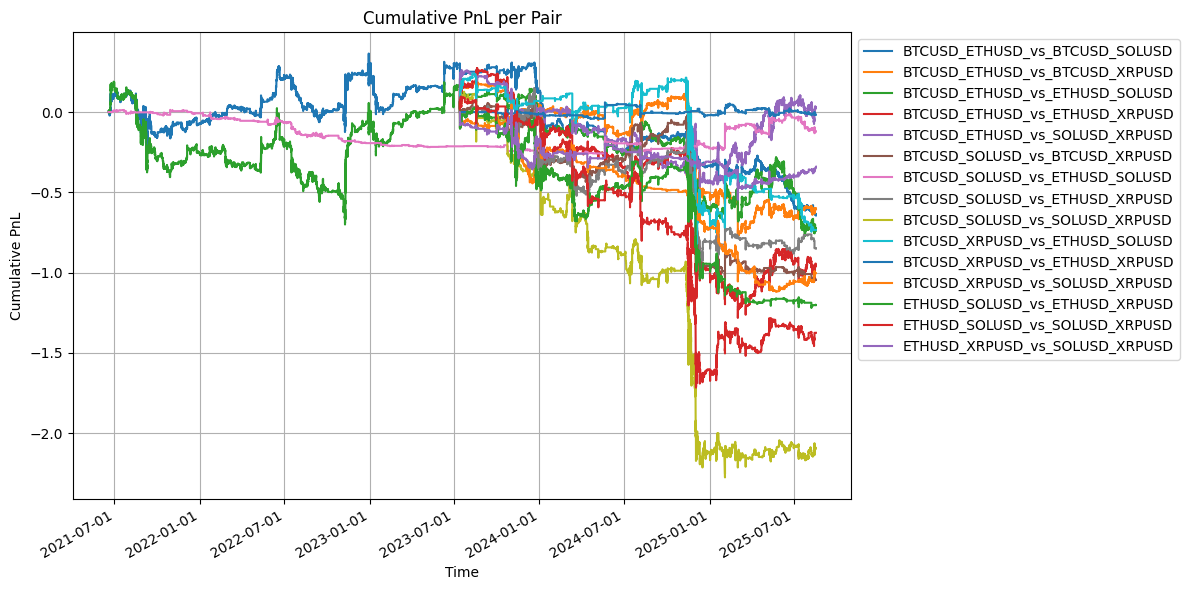

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))
for name, df in strategies.items():
    df_pd = df.select(["timestamp", "daily_pnl"]).to_pandas()
    df_pd["cum_pnl"] = df_pd["daily_pnl"].cumsum()
    ax.plot(df_pd["timestamp"], df_pd["cum_pnl"], label=name)

ax.set_title("Cumulative PnL per Pair")
ax.set_ylabel("Cumulative PnL")
ax.set_xlabel("Time")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.tight_layout()
plt.grid(True)
plt.show()
